<a href="https://colab.research.google.com/github/khailcon/Huehueteotl/blob/Alec_Code/Ceramic_Project_CHEM599.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Huehueteotl Ceramic Analysis Project

** https://github.com/khailcon/Huehueteotl **

##Tasks to accomplish
* Edge Detection of ceramics
* Void Detection via inverting color scheme
* Shape Detection
* Automation or For looping for a folder of images
* Share an online folder for raw data that we can access using code
* Make a yml

 

In [3]:
#import all necessary packages
import matplotlib.pyplot as plt
from math import sqrt
import skimage as sk
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh
from google.colab import drive
from pathlib import Path



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


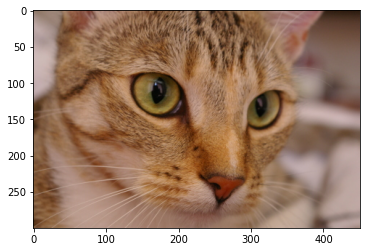

In [ ]:

def inclusion_counter(image, blob_algorithm = 'doh', max_sigma = 30, threshold = 0.1):
  """This function returns a rough count of the number of inclusions based on various algorithms

  Parameters
  -----------
  image : image variable
  blob_algorithm : str, optional
    Default: 'doh'. ('dog': Difference of Gaussian, 'log': Laplacian of Gaussian, 'doh': Determinant of Hessian, 'all': Average of all three)
    note- if 'all', threshold for doh will be one magnitude smaller
  max_sigma : float, optional
    Keep this high to detect large blobs
  threshold : float, optional
    Reduce this to detect less prominent blobs

  Returns
  --------
  int
    number of inclusions
  """
  image_gray = rgb2gray(image)
  if blob_algorithm == 'doh':
    blobs = blob_doh(image_gray, max_sigma = max_sigma, threshold = threshold)
    inclusions = len(blobs)
    return inclusions
  elif blob_algorithm == 'dog':
    blobs = blob_dog(image_gray, max_sigma = max_sigma, threshold = threshold)
    blobs[:,2] = blobs[:, 2] * sqrt(2)
    inclusions = len(blobs)
    return inclusions
  elif blob_algorithm == 'log':
    blobs = blob_log(image_gray, max_sigma = max_sigma, num_sigma = 10, threshold = threshold)
    blobs[:,2] = blobs[:, 2] * sqrt(2)
    inclusions = len(blobs)
    return inclusions
  elif blob_algorithm == 'all':
    blobs_doh = blob_doh(image_gray, max_sigma = max_sigma, threshold = .1*threshold)
    blobs_dog = blob_dog(image_gray, max_sigma = max_sigma, threshold = threshold)
    blobs_dog[:,2] = blobs_dog[:, 2] * sqrt(2)
    blobs_log = blob_log(image_gray, max_sigma = max_sigma, num_sigma = 10, threshold = threshold)
    blobs_log[:,2] = blobs_log[:, 2] * sqrt(2)
    inclusions = ((len(blobs_doh)+len(blobs_dog)+len(blobs_log))/3)
    return inclusions

/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


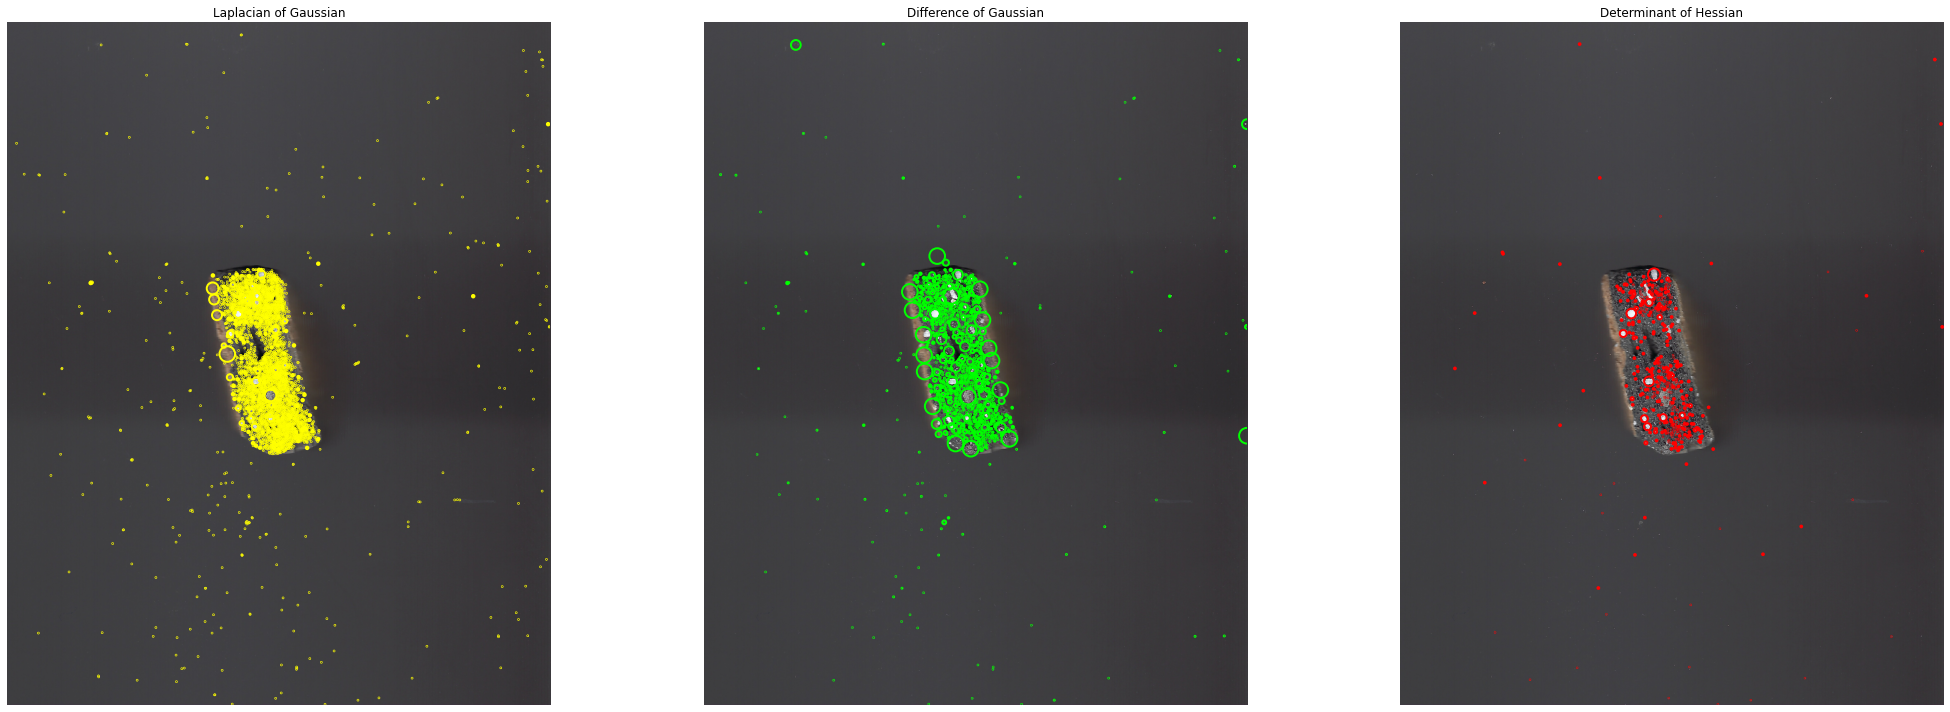

In [6]:

image = plt.imread('/content/drive/MyDrive/Ceramics_Images/Ceramic_13.jpeg')
image_gray = rgb2gray(image)

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

In [8]:
from skimage.filters import rank
from skimage.morphology import disk, square
from skimage.util import img_as_float, img_as_ubyte

selem = disk(2)



##Run a blur on the image first because these scans seem to be too noisy


/usr/local/lib/python3.7/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


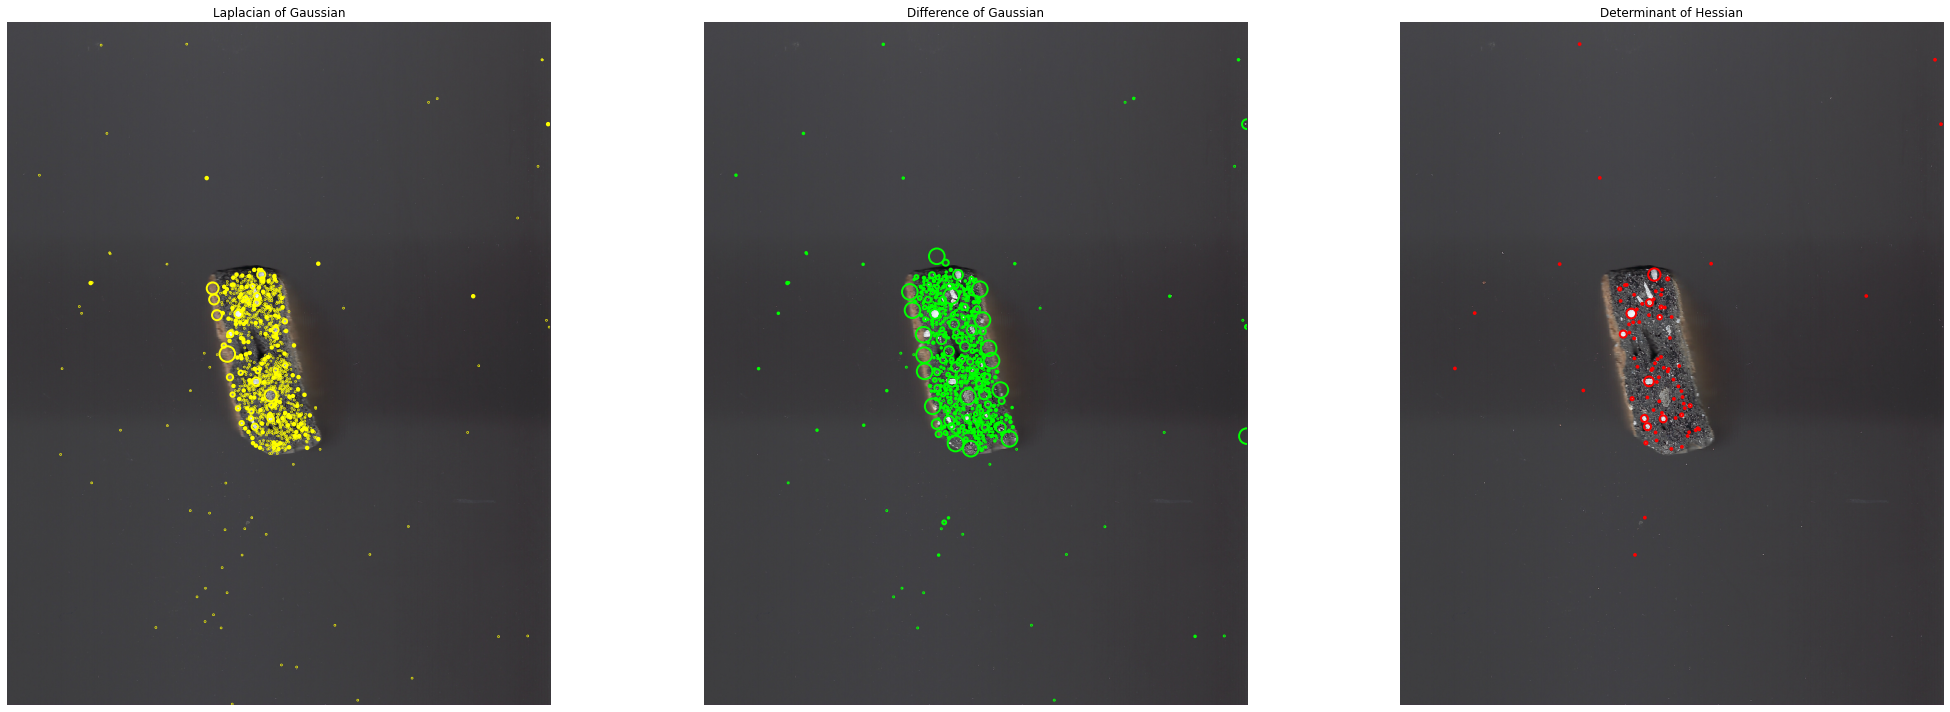

In [10]:
im2 = image
image_gray = rank.mean(rgb2gray(im2), selem = selem)

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(im2)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

DoH seems to have been over compensated, maybe we should adjust the settings of the blob detector, but DoG and LoG are still finding way too many small boobs where there aren't any. Perhaps adjust counter for a > < of radii? 